Loading clean data

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
df = pd.read_csv(os.path.join('..','data','mbti_1_clean.csv'))
df

,type,posts_clean
0,INFJ,"b""' and intj moments sportscenter not top t..."
1,INFJ,b'What has been the most life-changing experie...
2,INFJ,b' On repeat for most of today.'
3,INFJ,b'May the PerC Experience immerse you.'
4,INFJ,"b""The last thing my INFJ friend posted on his ..."
...,...,...
405258,INFP,b'I was going to close my facebook a few month...
405259,INFP,b'30 Seconds to Mars - All of my collections. ...
405260,INFP,"b'I have seen it, and i agree. I did actually ..."
405261,INFP,"b""Ok so i have just watched Underworld 4 (Awak..."


Visualising number and count of personality types

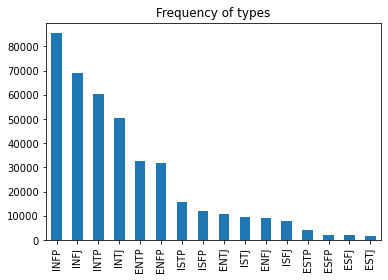

In [3]:
df['type'].value_counts().plot(kind='bar', title ='Frequency of types');

# Preprocessing

Building a tokeniser with numpy tensors

In [4]:
num_samples = df.shape[0]
seq_len = 512
print(f"""
Dataset Length: {num_samples}
Desired Sequence Length: {seq_len}
""")


Dataset Length: 405263
Desired Sequence Length: 512



In [5]:
%%time
from transformers import BertTokenizer

# initializing tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# tokenizing - this time returning Numpy tensors
tokens = tokenizer(df['posts_clean'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='np')

CPU times: user 4min 11s, sys: 23 s, total: 4min 34s
Wall time: 4min 56s


In [6]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [7]:
tokens['input_ids']

array([[101, 171, 107, ...,   0,   0,   0],
       [101, 171, 112, ...,   0,   0,   0],
       [101, 171, 112, ...,   0,   0,   0],
       ...,
       [101, 171, 112, ...,   0,   0,   0],
       [101, 171, 107, ...,   0,   0,   0],
       [101, 171, 107, ...,   0,   0,   0]])

In [8]:
tokens['token_type_ids']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [10]:
with open(os.path.join('..','data','myers_briggs_xids.npy'), 'wb') as f:
    np.save(f, tokens['input_ids'])
with open(os.path.join('..','data','myers_briggs_mask.npy'), 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [11]:
# freeing up memory
del tokens

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
arr = df['type'].values.reshape(-1,1)
transformed_labels = MultiLabelBinarizer().fit_transform(arr)
transformed_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [13]:
with open(os.path.join('..','data','myers-briggs.npy'), 'wb') as f:
    np.save(f, transformed_labels)

# Input Pipeline

In [14]:
with open(os.path.join('..','data','myers_briggs_xids.npy'), 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open(os.path.join('..','data','myers_briggs_mask.npy'), 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open(os.path.join('..','data','myers-briggs.npy'), 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [15]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

dataset.take(1)

<TakeDataset shapes: ((512,), (512,), (16,)), types: (tf.int64, tf.int64, tf.int64)>

In [16]:
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# using the dataset map method to apply this transformation
dataset = dataset.map(map_func)

dataset.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (16,)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.int64)>

In [17]:
batch_size = 16

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 16)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.int64)>

In [18]:
split = 0.9

# need to calculate how many batches must be taken to create 90% training set
size = int((Xids.shape[0] / batch_size) * split)

size

22796

In [19]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

# freeing up memory
del dataset

In [20]:
tf.data.experimental.save(train_ds, os.path.join('..','data','train'))
tf.data.experimental.save(val_ds, os.path.join('..','data','val'))

In [21]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 16), dtype=tf.int64, name=None))

In [22]:
val_ds.element_spec == train_ds.element_spec

True

In [23]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 16), dtype=tf.int64, name=None))

# Building and training the model

In [24]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

bert.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [25]:
import tensorflow as tf

# two input layers variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# accessing the transformer model within the bert object using the bert attribute 
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # accessing final activations 
# convert bert embeddings into 5 output classes
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(16, activation='softmax', name='outputs')(x)

In [26]:
# initializing model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# printing out model summary
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          ((None, 512, 768), ( 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         787456      bert[0][1]            

In [27]:
optimizer = tf.keras.optimizers.Adam(lr=5e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [28]:
element_spec = (
    {
    'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.float64, name='input_ids'),
    'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.float64, name='attention_mask')
    },
    tf.TensorSpec(shape=(16, 16), dtype=tf.float64, name=None)
)

# loading the training and validation sets
train_ds = tf.data.experimental.load(os.path.join('..','data','train'), element_spec=element_spec)
val_ds = tf.data.experimental.load(os.path.join('..','data','val'), element_spec=element_spec)

# viewing the input format
train_ds.take(1)

<TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 16)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

In [29]:
# building the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = 3
)

Epoch 1/3


InvalidArgumentError:  Data type mismatch at component 0: expected double but got int64.
	 [[node IteratorGetNext (defined at <ipython-input-29-90fe9bde5678>:2) ]] [Op:__inference_train_function_22399]

Function call stack:
train_function
